In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load advanced splits 
adv_lhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-LHB-empty-adv-2015-2024.csv')
adv_rhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-RHB-empty-adv-2015-2024.csv')
nonadv_lhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-LHB-empty-2015-2024.csv')
nonadv_rhb = pd.read_csv('../../MLBDATA/Raw/LeagueWideBatting/fg-custom-RHB-empty-2015-2024.csv')

df_lhb = adv_lhb[['Season', 'OBP', 'BABIP']].copy()
df_lhb['Handedness'] = 'LHB'
df_rhb = adv_rhb[['Season', 'OBP', 'BABIP']].copy()
df_rhb['Handedness'] = 'RHB'

df = pd.concat([df_lhb, df_rhb], ignore_index=True)
pivot = df.pivot(index='Season', columns='Handedness', values=['OBP', 'BABIP']).sort_index()

years = [y for y in pivot.index if y >= 2016]
did_rows = []
for year in years:
    prev = year - 1
    did_babip = (pivot.loc[year, ('BABIP', 'LHB')] - pivot.loc[prev, ('BABIP', 'LHB')]) - \
                (pivot.loc[year, ('BABIP', 'RHB')] - pivot.loc[prev, ('BABIP', 'RHB')])
    did_obp = (pivot.loc[year, ('OBP', 'LHB')] - pivot.loc[prev, ('OBP', 'LHB')]) - \
              (pivot.loc[year, ('OBP', 'RHB')] - pivot.loc[prev, ('OBP', 'RHB')])
    did_rows.append({'Season': year, 'DID_BABIP': did_babip, 'DID_OBP': did_obp})

did_df = pd.DataFrame(did_rows)

print(did_df)

   Season  DID_BABIP   DID_OBP
0    2016  -0.008729 -0.005793
1    2017   0.004211  0.004305
2    2018  -0.003490 -0.001735
3    2019   0.003047 -0.000370
4    2020  -0.020491 -0.014349
5    2021   0.016689  0.008922
6    2022  -0.009412 -0.006266
7    2023   0.009446  0.009451
8    2024  -0.001470 -0.001007


In [3]:
df_lhb = adv_lhb[['Season', 'OBP', 'BABIP']].assign(Hand='LHB')
df_rhb = adv_rhb[['Season', 'OBP', 'BABIP']].assign(Hand='RHB')
df = pd.concat([df_lhb, df_rhb], ignore_index=True)
pivot = df.pivot(index='Season', columns='Hand', values=['OBP', 'BABIP']).sort_index()

base_year = 2022
base_lhb_obp   = pivot.loc[base_year, ('OBP',   'LHB')]
base_rhb_obp   = pivot.loc[base_year, ('OBP',   'RHB')]
base_lhb_babip = pivot.loc[base_year, ('BABIP', 'LHB')]
base_rhb_babip = pivot.loc[base_year, ('BABIP', 'RHB')]

pivot['CF_OBP_LHB']   = base_lhb_obp   + (pivot[('OBP',   'RHB')] - base_rhb_obp)
pivot['CF_BABIP_LHB'] = base_lhb_babip + (pivot[('BABIP', 'RHB')] - base_rhb_babip)

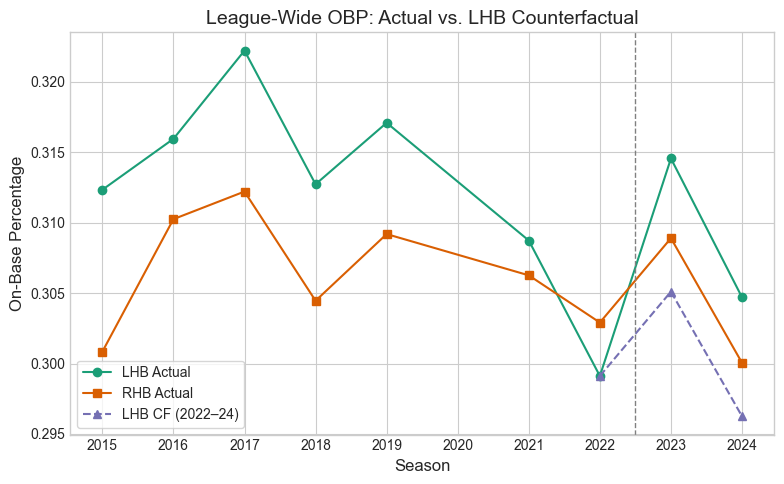

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':       12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize':10,
    'ytick.labelsize':10,
    'legend.fontsize':10
})

colors = {
    'LHB_actual':  '#1b9e77',   # teal
    'RHB_actual':  '#d95f02',   # orange
    'LHB_cf':      '#7570b3',   # purple
    'vline':       '0.5'        # medium gray
}

fig, ax = plt.subplots(figsize=(8,5))

# Filter out 2020 from actual plots
plot_years = pivot.index[pivot.index != 2020]

ax.plot(plot_years, pivot.loc[plot_years, ('OBP','LHB')],
        marker='o', linestyle='-', lw=1.5,
        color=colors['LHB_actual'], label='LHB Actual')
ax.plot(plot_years, pivot.loc[plot_years, ('OBP','RHB')],
        marker='s', linestyle='-', lw=1.5,
        color=colors['RHB_actual'], label='RHB Actual')

# Counterfactual (2022–2024 only)
cf = pivot.loc[2022:2024, 'CF_OBP_LHB']
ax.plot(cf.index, cf.values,
        marker='^', linestyle='--', lw=1.5,
        color=colors['LHB_cf'], label='LHB CF (2022–24)')

# Shift ban divider
ax.axvline(2022.5, color=colors['vline'], linestyle='--', lw=1)

# Full x-axis: 2015–2024
ax.set_xticks(range(2015, 2025))
ax.set_xticklabels(range(2015, 2025), rotation=0)

ax.set_xlabel('Season')
ax.set_ylabel('On-Base Percentage')
ax.set_title('League-Wide OBP: Actual vs. LHB Counterfactual')
ax.legend(loc='best', frameon=True)

fig.tight_layout()
plt.show()


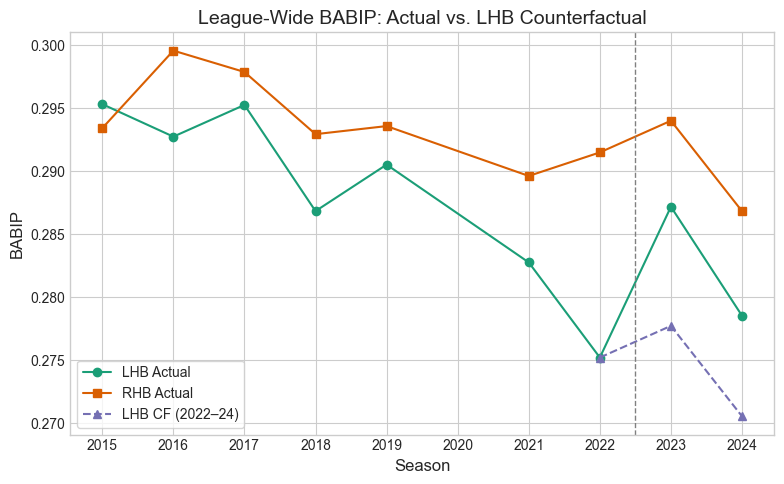

In [6]:
# Plot BABIP without 2020 data
fig, ax = plt.subplots(figsize=(8,5))

# Filter out 2020 for plotting
plot_years = pivot.index[pivot.index != 2020]

ax.plot(plot_years, pivot.loc[plot_years, ('BABIP','LHB')],
        marker='o', linestyle='-', lw=1.5,
        color=colors['LHB_actual'], label='LHB Actual')
ax.plot(plot_years, pivot.loc[plot_years, ('BABIP','RHB')],
        marker='s', linestyle='-', lw=1.5,
        color=colors['RHB_actual'], label='RHB Actual')

# Counterfactual BABIP (2022–2024 only)
cfb = pivot.loc[2022:2024, 'CF_BABIP_LHB']
ax.plot(cfb.index, cfb.values,
        marker='^', linestyle='--', lw=1.5,
        color=colors['LHB_cf'], label='LHB CF (2022–24)')

# Shift ban divider
ax.axvline(2022.5, color=colors['vline'], linestyle='--', lw=1)

# Full x-axis including 2020 (even if unplotted)
ax.set_xticks(range(2015, 2025))
ax.set_xticklabels(range(2015, 2025), rotation=0)

ax.set_xlabel('Season')
ax.set_ylabel('BABIP')
ax.set_title('League-Wide BABIP: Actual vs. LHB Counterfactual')
ax.legend(loc='best', frameon=True)

fig.tight_layout()
plt.show()
